In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt
import seaborn as sns 
import re
 
import warnings # supress warnings
warnings.filterwarnings('ignore')

In [2]:
import sklearn

from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures, scale, StandardScaler

from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet 

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.feature_selection import RFE, SelectKBest, f_regression
from sklearn.inspection import permutation_importance

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, RBF, Matern, RationalQuadratic
from sklearn.gaussian_process.kernels import Kernel, Hyperparameter, ConstantKernel
from sklearn.gaussian_process.kernels import GenericKernelMixin

from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score  

from sklearn.pipeline import make_pipeline

from sklearn.base import clone

In [3]:
def run_models():
    rf = RandomForestRegressor(n_estimators= 100, random_state= 10)
    gb = GradientBoostingRegressor(loss='quantile', alpha=0.5,
                                n_estimators=100, max_depth=10,
                                learning_rate=0.25, min_samples_leaf=9,
                                min_samples_split=2)
    lr = LinearRegression()
    rr = Ridge(alpha=0.01)
    lasso = Lasso(alpha=0.01)
    gpr1 = GaussianProcessRegressor(kernel=DotProduct() + WhiteKernel(),random_state=0)
    gpr2 = GaussianProcessRegressor(kernel=1.0 * RBF(length_scale=100.0, length_scale_bounds=(1e-2, 1e3))+ 
                                WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e+1)),alpha=0.0)
    gpr3 = GaussianProcessRegressor(kernel=ConstantKernel(1.0, (1e-2, 1e3)) * RBF(10, (1e-3, 1e4)),
                                n_restarts_optimizer=9)
    gpr4 = GaussianProcessRegressor(kernel=1.0 * RBF(length_scale=1.0, length_scale_bounds=(1e-1, 10.0)))
    gpr5 = GaussianProcessRegressor(kernel=1.0 * RationalQuadratic(length_scale=1.0, alpha=0.01))
    gpr6 = GaussianProcessRegressor(kernel=1.0 * Matern(length_scale=1.0, length_scale_bounds=(1e-2, 10.0),nu=0.35))
    models = [rf,gb,lr,rr,lasso,gpr1,gpr2,gpr3,gpr4,gpr5,gpr6]
    models_names = ["RF","GB","LR","RR","LASSO","gpr1","gpr2","gpr3","gpr4","gpr5","gpr6"]
    r2scores=[]
    rmse=[]
    count=0
    for model in models :
        predicted_y = []
        expected_y = []
        kf = KFold(n_splits= 10) 
        # partition data
        for train_index, test_index in kf.split(X, Y):
            # specific ".loc" syntax for working with dataframes
            x_train, x_test = X.loc[train_index], X.loc[test_index]
            y_train, y_test = Y[train_index], Y[test_index]

            # create and fit classifier
            model.fit(x_train, y_train)

            # store result from classification
            predicted_y.extend(model.predict(x_test))

            # store expected result for this specific fold
            expected_y.extend(y_test)
        
        r2 = metrics.r2_score(expected_y, predicted_y)
        r2scores.append(r2)
        
        err=np.sqrt(metrics.mean_squared_error(expected_y, predicted_y))
        rmse.append(err)
        
        print(models_names[count])
        print("R2: ",r2.__str__())
        print("RMSE: ",err)
        print("---------------------------------------")
        count+=1
    
    plt.rcdefaults()
    fig, ax = plt.subplots()

    x_pos = np.arange(len(models_names))
    ax.bar(x_pos, r2scores, align='center')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(models_names)
    ax.set_ylabel('R2 Score')
    #plt.savefig('imp.eps', format='eps')
    #plt.show()
    print(r2scores)

# Standard Scaling

In [4]:
data_std = pd.read_csv('scaled_standard_Coeff_D.csv', encoding='cp1252')   

In [5]:
data_std.columns.values

array(['Name', 'density', 'mean_A2B', 'mean_A2X', 'mean_B2X', 'mean_X2X',
       'std_A2B', 'std_A2X', 'std_B2X', 'std_X2X', 'E_coh', 'TF', 'OF',
       'A_Z', 'B_Z', 'X_Z', 'A_G', 'B_G', 'X_G', 'A_IEI', 'B_IEI',
       'X_IEI', 'A_IEII', 'B_IEII', 'X_IEII', 'A_EA', 'B_EA', 'X_EA',
       'A_ChiP', 'B_ChiP', 'X_ChiP', 'A_ChiA', 'B_ChiA', 'A_Rvdw',
       'B_Rvdw', 'X_Rvdw', 'B_Rc', 'B_Ra', 'A_MP', 'B_MP', 'A_Rho',
       'B_Rho', 'X_Rho', 'B_MV', 'X_MV', 'B_Hf', 'A_Kappa', 'B_Kappa',
       'X_Kappa', 'A_CvM', 'B_CvM', 'A_B', 'B_B', 'B_MendeleevNo',
       'Coeff_D'], dtype=object)

In [6]:
data_std.drop(['A_Z', 'B_Z', 'X_Z', 'A_G', 'B_G', 'X_G', 'A_IEI', 'B_IEI',
       'X_IEI', 'A_IEII', 'B_IEII', 'X_IEII', 'A_EA', 'B_EA', 'X_EA',
       'A_ChiP', 'B_ChiP', 'X_ChiP', 'A_ChiA', 'B_ChiA', 'A_Rvdw',
       'B_Rvdw', 'X_Rvdw', 'B_Rc', 'B_Ra', 'A_MP', 'B_MP', 'A_Rho',
       'B_Rho', 'X_Rho', 'B_MV', 'X_MV', 'B_Hf', 'A_Kappa', 'B_Kappa',
       'X_Kappa', 'A_CvM', 'B_CvM', 'A_B', 'B_B', 'B_MendeleevNo'
          ], axis=1, inplace = True)

In [7]:
data_std.fillna(0, inplace= True)

In [8]:
Y = data_std['Coeff_D'] 
X = data_std.drop(['Coeff_D','Name'], axis=1)

### Using CV technique

RF
R2:  0.7743138762076085
RMSE:  0.47506433647706237
---------------------------------------
GB
R2:  0.6189731010045356
RMSE:  0.617273763410907
---------------------------------------
LR
R2:  0.5328297734849293
RMSE:  0.683498519760702
---------------------------------------
RR
R2:  0.5331377410776712
RMSE:  0.6832731949391317
---------------------------------------
LASSO
R2:  0.5543475125228123
RMSE:  0.6675720841056699
---------------------------------------
gpr1
R2:  0.5550675895359474
RMSE:  0.6670325407834709
---------------------------------------
gpr2
R2:  0.5413415412530279
RMSE:  0.6772432788496111
---------------------------------------
gpr3
R2:  0.27941543410529424
RMSE:  0.8488725262927914
---------------------------------------
gpr4
R2:  0.3198662374801404
RMSE:  0.8247022265762713
---------------------------------------
gpr5
R2:  0.2428796880972015
RMSE:  0.8701266068238567
---------------------------------------
gpr6
R2:  0.7320902348695898
RMSE:  0.5176000049559604
--

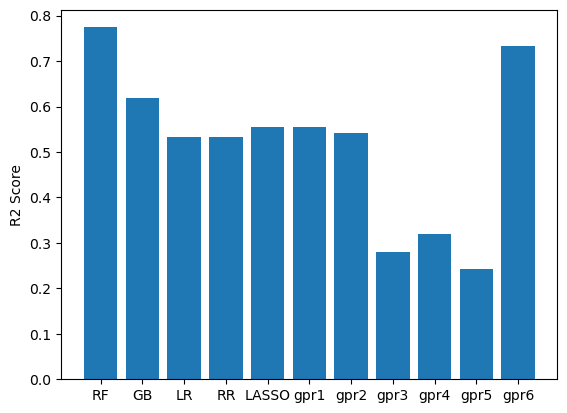

In [9]:
run_models()

## Feature selection


In [10]:
#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=f_regression, k=10)
fit = bestfeatures.fit(X,Y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Feature','Score']  #naming the dataframe columns
print(featureScores.nlargest(30,'Score'))  #print 10 best features

     Feature      Score
1   mean_A2B  47.599974
4   mean_X2X  33.749541
2   mean_A2X  21.966084
11        OF  19.573438
7    std_B2X  16.294713
6    std_A2X  12.148069
9      E_coh  11.712526
10        TF   7.108773
5    std_A2B   7.056710
8    std_X2X   5.471454
0    density   1.218888
3   mean_B2X   0.044770


In [11]:
featureScores.nlargest(40,'Score')['Feature'].values

array(['mean_A2B', 'mean_X2X', 'mean_A2X', 'OF', 'std_B2X', 'std_A2X',
       'E_coh', 'TF', 'std_A2B', 'std_X2X', 'density', 'mean_B2X'],
      dtype=object)

In [12]:
X=X[featureScores.nlargest(40,'Score')['Feature'].values]

RF
R2:  0.7773763478662994
RMSE:  0.4718301093971226
---------------------------------------
GB
R2:  0.6342542420316815
RMSE:  0.6047691774291399
---------------------------------------
LR
R2:  0.5328297734849292
RMSE:  0.6834985197607021
---------------------------------------
RR
R2:  0.5331377410776714
RMSE:  0.6832731949391316
---------------------------------------
LASSO
R2:  0.5543761121647648
RMSE:  0.6675506631224594
---------------------------------------
gpr1
R2:  0.555067589539809
RMSE:  0.6670325407805763
---------------------------------------
gpr2
R2:  0.5413415412530291
RMSE:  0.6772432788496102
---------------------------------------
gpr3
R2:  0.2128124917001022
RMSE:  0.8872358808681589
---------------------------------------
gpr4
R2:  0.31986623748014387
RMSE:  0.8247022265762692
---------------------------------------
gpr5
R2:  0.24287968809671479
RMSE:  0.8701266068241363
---------------------------------------
gpr6
R2:  0.7320902348695881
RMSE:  0.517600004955962
--

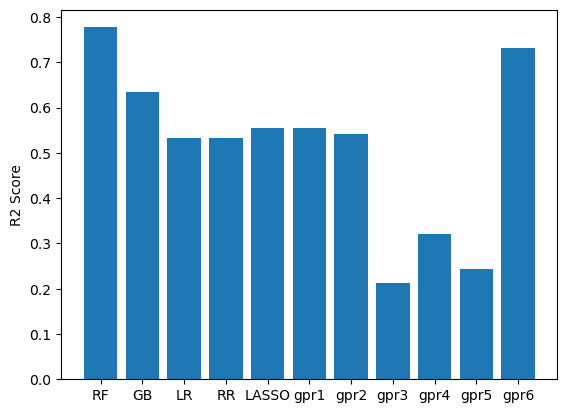

In [13]:
run_models()

In [14]:
featureScores.nlargest(30,'Score')['Feature'].values

array(['mean_A2B', 'mean_X2X', 'mean_A2X', 'OF', 'std_B2X', 'std_A2X',
       'E_coh', 'TF', 'std_A2B', 'std_X2X', 'density', 'mean_B2X'],
      dtype=object)

In [15]:
X=X[featureScores.nlargest(30,'Score')['Feature'].values]

RF
R2:  0.7773763478662994
RMSE:  0.4718301093971226
---------------------------------------
GB
R2:  0.6114018932072616
RMSE:  0.6233763765116052
---------------------------------------
LR
R2:  0.5328297734849292
RMSE:  0.6834985197607021
---------------------------------------
RR
R2:  0.5331377410776714
RMSE:  0.6832731949391316
---------------------------------------
LASSO
R2:  0.5543761121647648
RMSE:  0.6675506631224594
---------------------------------------
gpr1
R2:  0.555067589539809
RMSE:  0.6670325407805763
---------------------------------------
gpr2
R2:  0.5413415412530291
RMSE:  0.6772432788496102
---------------------------------------
gpr3
R2:  0.16906107964342443
RMSE:  0.9115585117569664
---------------------------------------
gpr4
R2:  0.31986623748014387
RMSE:  0.8247022265762692
---------------------------------------
gpr5
R2:  0.24287968809671479
RMSE:  0.8701266068241363
---------------------------------------
gpr6
R2:  0.7320902348695881
RMSE:  0.517600004955962
-

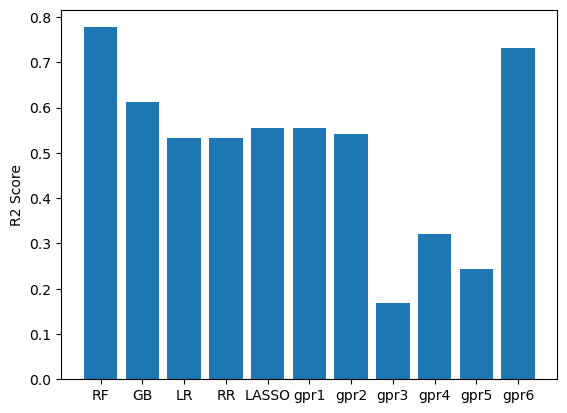

In [16]:
run_models()

In [17]:
featureScores.nlargest(20,'Score')['Feature'].values

array(['mean_A2B', 'mean_X2X', 'mean_A2X', 'OF', 'std_B2X', 'std_A2X',
       'E_coh', 'TF', 'std_A2B', 'std_X2X', 'density', 'mean_B2X'],
      dtype=object)

In [18]:
X=X[featureScores.nlargest(20,'Score')['Feature'].values]

RF
R2:  0.7773763478662994
RMSE:  0.4718301093971226
---------------------------------------
GB
R2:  0.5573406293450761
RMSE:  0.6653265143182886
---------------------------------------
LR
R2:  0.5328297734849292
RMSE:  0.6834985197607021
---------------------------------------
RR
R2:  0.5331377410776714
RMSE:  0.6832731949391316
---------------------------------------
LASSO
R2:  0.5543761121647648
RMSE:  0.6675506631224594
---------------------------------------
gpr1
R2:  0.555067589539809
RMSE:  0.6670325407805763
---------------------------------------
gpr2
R2:  0.5413415412530291
RMSE:  0.6772432788496102
---------------------------------------
gpr3
R2:  0.2837704365511563
RMSE:  0.846303470067826
---------------------------------------
gpr4
R2:  0.31986623748014387
RMSE:  0.8247022265762692
---------------------------------------
gpr5
R2:  0.24287968809671479
RMSE:  0.8701266068241363
---------------------------------------
gpr6
R2:  0.7320902348695881
RMSE:  0.517600004955962
---

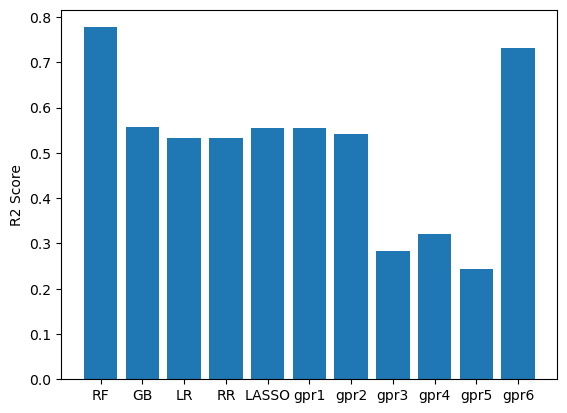

In [19]:
run_models()

In [20]:
featureScores.nlargest(10,'Score')['Feature'].values

array(['mean_A2B', 'mean_X2X', 'mean_A2X', 'OF', 'std_B2X', 'std_A2X',
       'E_coh', 'TF', 'std_A2B', 'std_X2X'], dtype=object)

In [21]:
X=X[featureScores.nlargest(10,'Score')['Feature'].values]

RF
R2:  0.844858420655348
RMSE:  0.39388015860747805
---------------------------------------
GB
R2:  0.48252724613285536
RMSE:  0.7193557908762149
---------------------------------------
LR
R2:  0.3425679585734821
RMSE:  0.810821830876869
---------------------------------------
RR
R2:  0.34285294182621173
RMSE:  0.8106460745441183
---------------------------------------
LASSO
R2:  0.3814446230348528
RMSE:  0.786482915876211
---------------------------------------
gpr1
R2:  0.3805414401991062
RMSE:  0.7870568974355626
---------------------------------------
gpr2
R2:  0.630909211125374
RMSE:  0.6075284263922356
---------------------------------------
gpr3
R2:  0.31793017093459053
RMSE:  0.8258751897625993
---------------------------------------
gpr4
R2:  0.3350478149838393
RMSE:  0.815446003740383
---------------------------------------
gpr5
R2:  0.6104162818628245
RMSE:  0.6241664186234113
---------------------------------------
gpr6
R2:  0.7084472826096532
RMSE:  0.5399562180310056
---

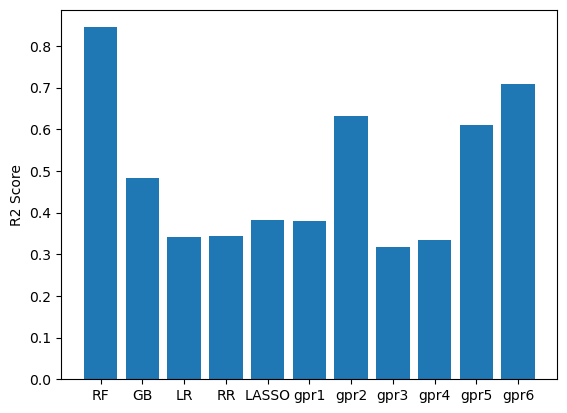

In [22]:
run_models()

# Min-Max scaling

In [23]:
data_mm = pd.read_csv('scaled_minmax_Coeff_D.csv', encoding='cp1252')

In [24]:
data_mm.drop(['A_Z', 'B_Z', 'X_Z', 'A_G', 'B_G', 'X_G', 'A_IEI', 'B_IEI',
       'X_IEI', 'A_IEII', 'B_IEII', 'X_IEII', 'A_EA', 'B_EA', 'X_EA',
       'A_ChiP', 'B_ChiP', 'X_ChiP', 'A_ChiA', 'B_ChiA', 'A_Rvdw',
       'B_Rvdw', 'X_Rvdw', 'B_Rc', 'B_Ra', 'A_MP', 'B_MP', 'A_Rho',
       'B_Rho', 'X_Rho', 'B_MV', 'X_MV', 'B_Hf', 'A_Kappa', 'B_Kappa',
       'X_Kappa', 'A_CvM', 'B_CvM', 'A_B', 'B_B', 'B_MendeleevNo'
          ], axis=1, inplace = True)

In [25]:
data_mm.fillna(0, inplace= True)

In [26]:
Y = data_mm['Coeff_D'] 
X = data_mm.drop(['Coeff_D','Name'], axis=1)

### Using CV technique

RF
R2:  0.7742441330991284
RMSE:  0.10924448369209835
---------------------------------------
GB
R2:  0.6209902710409717
RMSE:  0.14154846784474798
---------------------------------------
LR
R2:  0.5328297734849294
RMSE:  0.15715115312510558
---------------------------------------
RR
R2:  0.53735766897802
RMSE:  0.15638773059249314
---------------------------------------
LASSO
R2:  0.3733137500491286
RMSE:  0.18201411850140764
---------------------------------------
gpr1
R2:  0.5355914520385829
RMSE:  0.1566859647986228
---------------------------------------
gpr2
R2:  0.625922784359507
RMSE:  0.1406243804802682
---------------------------------------
gpr3
R2:  -0.17888986282788455
RMSE:  0.24964140050976408
---------------------------------------
gpr4
R2:  -0.1288455194524818
RMSE:  0.2442852531091275
---------------------------------------
gpr5
R2:  0.6378276738844711
RMSE:  0.13836862489267673
---------------------------------------
gpr6
R2:  0.7207609811764446
RMSE:  0.121497696850

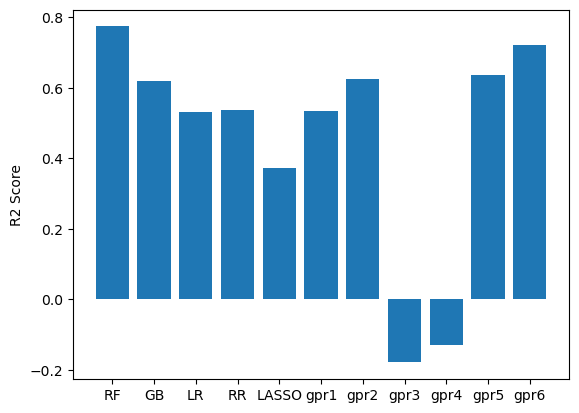

In [27]:
run_models()

## Feature selection


In [28]:
#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=f_regression, k=10)
fit = bestfeatures.fit(X,Y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Feature','Score']  #naming the dataframe columns
print(featureScores.nlargest(30,'Score'))  #print 10 best features

     Feature      Score
1   mean_A2B  47.599974
4   mean_X2X  33.749541
2   mean_A2X  21.966084
11        OF  19.573438
7    std_B2X  16.294713
6    std_A2X  12.148069
9      E_coh  11.712526
10        TF   7.108773
5    std_A2B   7.056710
8    std_X2X   5.471454
0    density   1.218888
3   mean_B2X   0.044770


In [29]:
featureScores.nlargest(40,'Score')['Feature'].values

array(['mean_A2B', 'mean_X2X', 'mean_A2X', 'OF', 'std_B2X', 'std_A2X',
       'E_coh', 'TF', 'std_A2B', 'std_X2X', 'density', 'mean_B2X'],
      dtype=object)

In [30]:
X=X[featureScores.nlargest(40,'Score')['Feature'].values]

RF
R2:  0.7669338763260504
RMSE:  0.11099912883022142
---------------------------------------
GB
R2:  0.6179762069968873
RMSE:  0.1421101833733123
---------------------------------------
LR
R2:  0.5328297734849297
RMSE:  0.15715115312510555
---------------------------------------
RR
R2:  0.53735766897802
RMSE:  0.15638773059249314
---------------------------------------
LASSO
R2:  0.37331934958161495
RMSE:  0.18201330533832463
---------------------------------------
gpr1
R2:  0.5355914520385487
RMSE:  0.15668596479862856
---------------------------------------
gpr2
R2:  0.625922784359507
RMSE:  0.1406243804802682
---------------------------------------
gpr3
R2:  -0.12884579670939855
RMSE:  0.24428528310870262
---------------------------------------
gpr4
R2:  -0.12884551945272582
RMSE:  0.2442852531091539
---------------------------------------
gpr5
R2:  0.6378276738846116
RMSE:  0.13836862489264992
---------------------------------------
gpr6
R2:  0.7207610175466193
RMSE:  0.1214976889

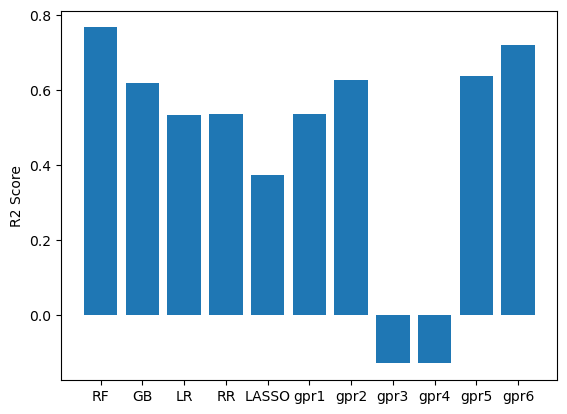

In [31]:
run_models()

In [32]:
featureScores.nlargest(30,'Score')['Feature'].values

array(['mean_A2B', 'mean_X2X', 'mean_A2X', 'OF', 'std_B2X', 'std_A2X',
       'E_coh', 'TF', 'std_A2B', 'std_X2X', 'density', 'mean_B2X'],
      dtype=object)

In [33]:
X=X[featureScores.nlargest(30,'Score')['Feature'].values]

RF
R2:  0.7669338763260504
RMSE:  0.11099912883022142
---------------------------------------
GB
R2:  0.6170140309337564
RMSE:  0.14228903221904052
---------------------------------------
LR
R2:  0.5328297734849297
RMSE:  0.15715115312510555
---------------------------------------
RR
R2:  0.53735766897802
RMSE:  0.15638773059249314
---------------------------------------
LASSO
R2:  0.37331934958161495
RMSE:  0.18201330533832463
---------------------------------------
gpr1
R2:  0.5355914520385487
RMSE:  0.15668596479862856
---------------------------------------
gpr2
R2:  0.625922784359507
RMSE:  0.1406243804802682
---------------------------------------
gpr3
R2:  -0.1288458555908214
RMSE:  0.24428528947975212
---------------------------------------
gpr4
R2:  -0.12884551945272582
RMSE:  0.2442852531091539
---------------------------------------
gpr5
R2:  0.6378276738846116
RMSE:  0.13836862489264992
---------------------------------------
gpr6
R2:  0.7207610175466193
RMSE:  0.1214976889

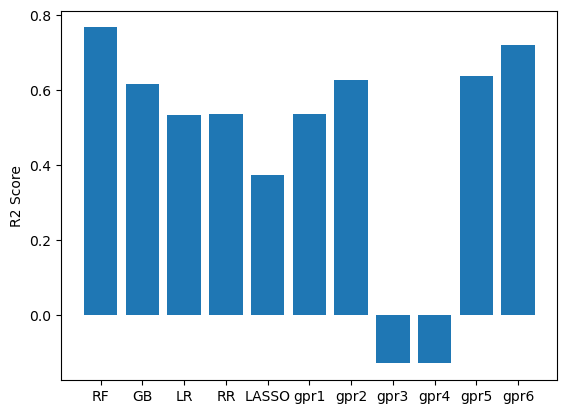

In [34]:
run_models()

In [35]:
featureScores.nlargest(20,'Score')['Feature'].values

array(['mean_A2B', 'mean_X2X', 'mean_A2X', 'OF', 'std_B2X', 'std_A2X',
       'E_coh', 'TF', 'std_A2B', 'std_X2X', 'density', 'mean_B2X'],
      dtype=object)

In [36]:
X=X[featureScores.nlargest(20,'Score')['Feature'].values]

RF
R2:  0.7669338763260504
RMSE:  0.11099912883022142
---------------------------------------
GB
R2:  0.6082876403991071
RMSE:  0.14390094010491972
---------------------------------------
LR
R2:  0.5328297734849297
RMSE:  0.15715115312510555
---------------------------------------
RR
R2:  0.53735766897802
RMSE:  0.15638773059249314
---------------------------------------
LASSO
R2:  0.37331934958161495
RMSE:  0.18201330533832463
---------------------------------------
gpr1
R2:  0.5355914520385487
RMSE:  0.15668596479862856
---------------------------------------
gpr2
R2:  0.625922784359507
RMSE:  0.1406243804802682
---------------------------------------
gpr3
R2:  -0.12884580908992893
RMSE:  0.24428528444829276
---------------------------------------
gpr4
R2:  -0.12884551945272582
RMSE:  0.2442852531091539
---------------------------------------
gpr5
R2:  0.6378276738846116
RMSE:  0.13836862489264992
---------------------------------------
gpr6
R2:  0.7207610175466193
RMSE:  0.121497688

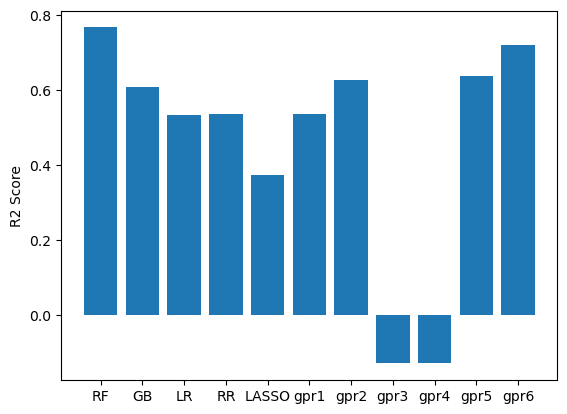

In [37]:
run_models()

In [38]:
featureScores.nlargest(10,'Score')['Feature'].values

array(['mean_A2B', 'mean_X2X', 'mean_A2X', 'OF', 'std_B2X', 'std_A2X',
       'E_coh', 'TF', 'std_A2B', 'std_X2X'], dtype=object)

In [39]:
X=X[featureScores.nlargest(10,'Score')['Feature'].values]

RF
R2:  0.8506465510170924
RMSE:  0.08885617655128013
---------------------------------------
GB
R2:  0.45505995008760336
RMSE:  0.16972833750442215
---------------------------------------
LR
R2:  0.3425679585734821
RMSE:  0.18642554741145684
---------------------------------------
RR
R2:  0.35042469944426013
RMSE:  0.18530824593271208
---------------------------------------
LASSO
R2:  0.37396043663355993
RMSE:  0.1819201827640658
---------------------------------------
gpr1
R2:  0.3284250893531585
RMSE:  0.18842009794026632
---------------------------------------
gpr2
R2:  0.5996953057871601
RMSE:  0.14547063519687795
---------------------------------------
gpr3
R2:  -0.7753098116381056
RMSE:  0.30634942559697503
---------------------------------------
gpr4
R2:  -0.7753098467669095
RMSE:  0.30634942862790765
---------------------------------------
gpr5
R2:  0.6576100418578728
RMSE:  0.13453661708136783
---------------------------------------
gpr6
R2:  0.6940101412381995
RMSE:  0.12718

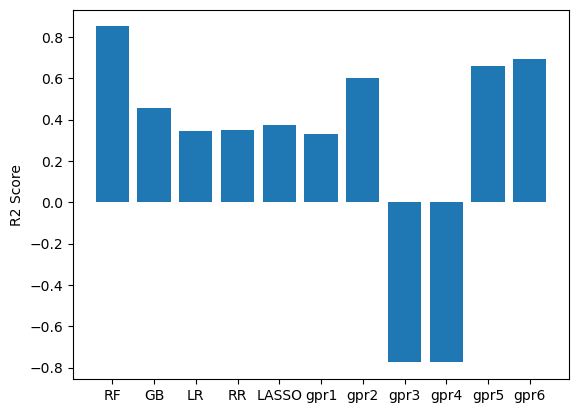

In [40]:
run_models()